# Simon's Algorithm
<hr></hr>

[Simon's algorithm](https://en.wikipedia.org/wiki/Simon%27s_problem), introduced by Daniel R. Simon in 1994, corresponded to the first proposal of a quantum algorithm that solves a problem **exponentially** faster than the best known classical approach. [[Simon94]](https://epubs.siam.org/doi/pdf/10.1137/S0097539796298637). 

Even though the problem solved by Simon's algorithm (dubbed Simon's problem) isn't of any practical relevance, it laid the foundation for what would become Shor's algorithm, which is one of the very few quantum algorithms with a proven advantage for a real-world application.

<a name="back1"></a> Simon's problem is similar to the Bernstein-Vazinari problem in that we are tasked with finding a secret string $s$. However, the function that encodes $s$ is different[$^*$](#footnote1). In Simon's problem, we are given a function that takes an $n$-bit input $x$ and produces an $n$-bit output $f(x)$ (i.e., $f: {0, 1}^n \longmapsto {0, 1}^n$) where we are promised that $f(x) = f(s \oplus x).$ Here, $s$ is an $n$-bit string and $\oplus$ denotes the bitwise XOR (addition modulo-2) operation:

$$ s \oplus x = \underbrace{s_{n-1} \oplus x_{n-1}}_{(n-1)^{\text{th}} \text{ bit}} \dots \underbrace{s_{1} \oplus x_{1}}_{1^{\text{st}} \text{ bit}} \, \underbrace{s_{0} \oplus x_{0}}_{0^{\text{th}} \text{ bit}} .$$

This condition then generates a function for which two values of $x$ take the same value of $f(x)$ (i.e., the function is two-to-one). For example, given the string $s = 110$ we can have a function $f: \{0, 1\}^3 \longmapsto \{0, 1\}^3$, with the following mapping:

$$
\begin{split}
\begin{aligned}
f(000) &= 011
\\
f(001) &= 100
\\
f(010) &= 010
\\
f(011) &= 111
\\
f(100) &= 010
\\
f(101) &= 111
\\
f(110) &= 011
\\
f(111) &= 100
\end{aligned}
\end{split}
$$

Notice how, for example, for $x = 001$ and $x = (110 \oplus 001) = 111,$ we obtain the same $f(x) = 100.$ 

It is worth noting that, for the purpose of Simon's problem, the the value that $f(x)$ takes for each individual $x$ is completely arbitrary as long as the condition $f(x) = f(s \oplus x)$ is met.

Let's now use python to generate an arbitrary function $f(x)$ for every possible value of $x$ given a string $s$:

In [1]:
import numpy as np

In [2]:
def fx_simon(s_int, n):
    fx_lst = [0]*2**n
    x_used = []
    fx_avail = list(range(2**n))
    
    for x_int in range(2**n):
        if x_int in x_used: continue

        x_pair = s_int ^ x_int
        x_used.extend((x_int, x_pair))
        
        # pick random f(x) value and remove from available list
        fx_int = np.random.choice(fx_avail)
        fx_avail.remove(fx_int)
        
        # assign f(x) value to x and s⊕x
        fx_lst[x_int] = fx_int
        fx_lst[x_pair] = fx_int
        
    return fx_lst

In [3]:
s = '1101'          # String (pick value different from all-zeros string).
n = len(s)
s_int = int(s, 2)

fx_lst = fx_simon(s_int, n)

print(f'Outcomes for s = {s}\n')
print('x',' '*(n), 'f(x)')

for x_int, fx_int in enumerate(fx_lst):
    x = np.binary_repr(x_int,n)
    fx = np.binary_repr(fx_int,n)
    
    print(x, ' ', fx)

Outcomes for s = 1101

x      f(x)
0000   1111
0001   1110
0010   0101
0011   0111
0100   1011
0101   0110
0110   1010
0111   0000
1000   0110
1001   1011
1010   0000
1011   1010
1100   1110
1101   1111
1110   0111
1111   0101


Rerunning the cell above will result different values of $f(x)$ (picked at random) for each corresponding $x$. However, the condition $f(x) = f(s \oplus x)$ is always fulfilled.

## 1.1 Classical Approach

To solve Simon's problem classically, we have to evaluate the function $f(x)$ for different values of $x$ until we get a repeated output. If the values of $x$ for which we get the repeated outcome are the pair $\{a, b\},$ we then have $f(a) = f(b).$ Now, since $f(x) = f(s \oplus x)$ for all values of $x,$ this implies that $b = s \oplus a$. We can then find $s$  by taking the **XOR** with $a$ on both sides of this expression:

$$ 
\begin{aligned}
b &= s \oplus a
\\
\\
b \oplus a &= (s \oplus a) \oplus a
\\
\\
b \oplus a &= s \oplus (a \oplus a)
\\
\\
b \oplus a &= s.
\end{aligned}
$$

This equality holds because taking the bitwise **XOR** of any number with itself is always zero (i.e., $a \oplus a = 0$).

So, if we get very lucky, it takes only $2$ tries to find repeated outcomes that allows us to extract $s.$ However, since for a string of length $n$ we can have $2^n$ different inputs for which there are $2^n/2$ corresponding $f(x)$ values (since $f(x)$ is two-to-one), it can take up to $2^n/2 + 1$ tries to find the inputs for two matching outputs.

Let's now create a python function that naïvely encodes the $f(x) = f(s \oplus x)$ condition into a unitary black box $U_f$ (details on this and a more efficient implementation are discussed in section 1.3).

In [4]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

In [5]:
def black_box(n):
    # Black box of Simon's problem using naïve implementation.
    # It encodes it each product element from a sum of products asan MCX gate.
    s_int = np.random.randint(1, 2**n)
    s = np.binary_repr(s_int, n)
    
    fx_controls = [[] for _ in range(n)]
    fx_lst = fx_simon(s_int, n)
    
    # Iterate over fx_list where each index is x, value is integer value of fx
    # and find the control values for each fx_i that evaluates to 1.
    for x_int, fx in enumerate(fx_lst):
        for bit, fx_bit in enumerate(reversed(np.binary_repr(fx, n))):
            if fx_bit == '1':
                fx_controls[bit].append(x_int)
    
    qc_bb = QuantumCircuit(2*n, name='Black Box')
    for i, controls in enumerate(fx_controls):
        for int_ctrl_state in controls:
            ctrl_state = np.binary_repr(int_ctrl_state,n)
            qc_bb.mcx(list(range(n,2*n)),i,ctrl_state=ctrl_state)
        qc_bb.barrier()
        
    return qc_bb, s

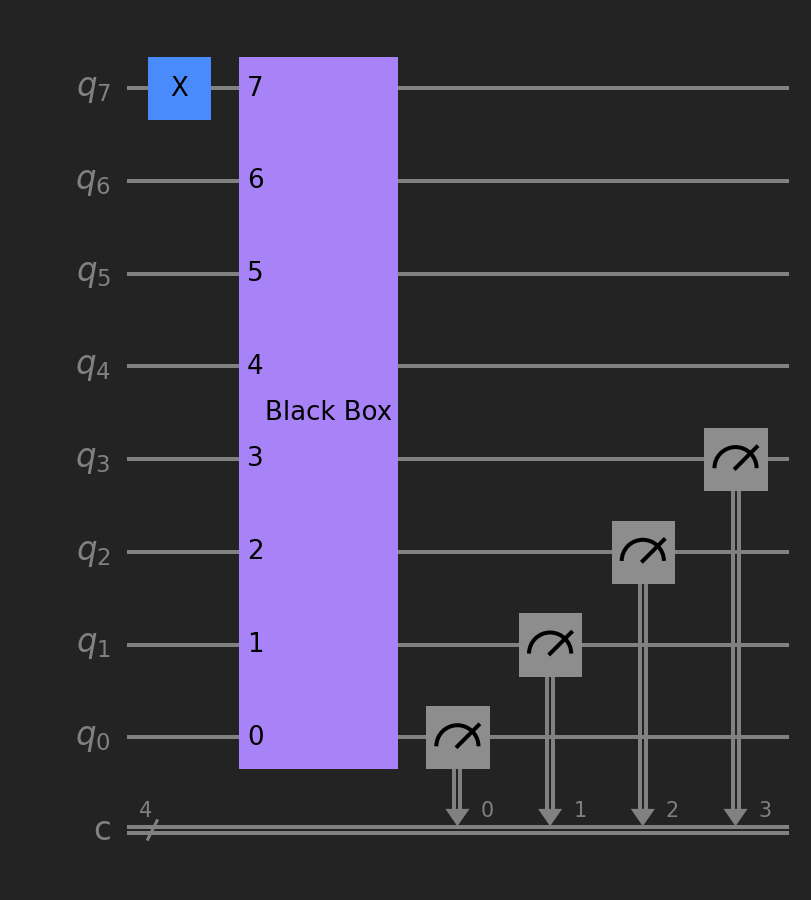

In [6]:
# Draw example circuit to solve B-V's problem classically (n = 4, x = 1000)
n = 4
bb, _ = black_box(n)

qc = QuantumCircuit(2*n,n)
qc.x(2*n-1)
qc.append(bb,range(2*n))
qc.measure(range(n),range(n))
qc.draw()

We can now try each possible input $x$ and check that, for the encoded string $s$, our unitary $U_f$ does correctly return the expected outputs:

In [7]:
# Go over every input and output

n = 3                        # String length
bb, s = black_box(n)         # Generate black box and secret string
fx_meas = {}                 # Dict where keys are measured fx and values are corresponding x

simulator = AerSimulator()

print(f'Outcomes for s = {s}\n')
print('x',' '*(n), 'f(x)')
for x_int in range(2**n):
    
    x = np.binary_repr(x_int, n)
    input_ones = [i+n for i, v in enumerate(reversed(x)) if v == '1']
    
    qc = QuantumCircuit(2*n,n)
    if input_ones: qc.x(input_ones)
    qc.append(bb,range(2*n))
    qc.measure(range(n),range(n))
    
    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots=1, memory=True)  # Run one simulation to get f(x) outcome
    fx = job.result().get_memory()[0]
    
    print(x, ' ', fx)

Outcomes for s = 010

x     f(x)
000   101
001   100
010   101
011   100
100   011
101   000
110   011
111   000


Let us now pick different values of $x$ until we find two matching values of $f(x).$ We can then find the randomly encoded secret string $s$ by taking the **XOR** between the inputs of the corresponding matching outputs:

In [8]:
n = 4                        # String length
bb, s = black_box(n)         # Generate black box and secret string

fx_meas = {}                  # Dictionary to store string extracted from f(x) and the corresponding value of x
match = False                 # Has a match been found?
x_avail = list(range(2**n))   # List with all possible x values to try
n_tries = 0

while not match:
    
    # pick x at random
    x_int = np.random.choice(x_avail)
    x_avail.remove(x_int)
    x = np.binary_repr(x_int, n)
    
    # evaluate Uf for selected x
    input_ones = [i+n for i, v in enumerate(reversed(x)) if v == '1']
    
    qc = QuantumCircuit(2*n,n)
    if input_ones: qc.x(input_ones)
        
    qc.append(bb,range(2*n))
    qc.measure(range(n),range(n))
    
    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots=1, memory=True)
    fx = job.result().get_memory()[0]
    
    n_tries += 1
    
    if fx in fx_meas:
        s_out = np.binary_repr(x_int ^ int(fx_meas[fx], 2), n)
        match = True
    else:
        fx_meas[fx] = x
        
print(f'secret string: {s}')
print(f'extracted string: {s_out}')
print(f'number of tries: {n_tries} (out of {int(2**n/2)} possible outputs)')

secret string: 1001
extracted string: 1001
number of tries: 5 (out of 8 possible outputs)


Calculating the probability of classically finding a secret string of length $n$ after a certain number of tries $r$, is akin to solving the [birthday paradox problem](https://en.wikipedia.org/wiki/Birthday_problem). This means that, for a total of $2^n$ possible values of $x$ it takes roughly $2^{n/2}$ tries to to find a match for $f(x)$ with probability larger than $50 \%$ (when $n$ is large). What this means is that, the probability of successfully finding $s$ classically, grows **exponentially** with the length of the string $n.$

The plot below shows the results for the probability of finding a secret string of length $n = 5$ after a given number of tries $r:$
<img src="images/04_03_01_classical_probs.png" align = "center" width="520"/>

It can be seen that only after $r = 6$ tries, the probability is over $50 \%,$ which is in line from the expectation of requiring value larger than $2^{5/2} \approx 5.66.$

## Footnotes

<a name="footnote1"></a><span style="font-size: smaller;">$^*$The definition of Simon's problem is actually broader than what is described above. More generally, Simon's problem considers an $n$ to $m$ function $f: \{0, 1\}^n \longmapsto \{0, 1\}^n, \, m \geq n,$ which meets the condition $f(x) = f(s \oplus x).$ The function is either one-to-one (when $s$ is the all-zeros string) or two-to-one (when $s$ is any other string). Simon's decision problem consists of finding which of these two types of function $f(x)$ is. Simon's no-decision problem consists in finding what the bit-string $s$ is, which is what is described in this chapter for the case in which $m = n.$ ([go back](#back1))</span>